In [1]:
import os
from scipy import ndimage
import nibabel as nib
from keras.utils import get_file
import torchio as tio
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import random
import shutil

C:\Users\maxim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

# THIS CODE IS NOW REDUNDANT THE FULL DATABASE CAN BE FOUND HERE : https://www.kaggle.com/datasets/mathurinache/mosmeddata-chest-ct-scans-with-covid19/data


# url_1 = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
# url_2 = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"

# file_path = "c:\\Users\\maxim\\OneDrive\\Desktop\\Research\\Experiment_1\\datasets\\CT-0.zip"
# if os.path.exists(file_path):
#     os.remove(file_path)  # Deletes the incomplete file

# # Directory where the files will be stored
# cache_dir = os.getcwd()  # Current working directory

# # Download the first file
# filename_1 = get_file("CT-0.zip", url_1, cache_dir=cache_dir)

# # Download the second file
# filename_2 = get_file("CT-23.zip", url_2, cache_dir=cache_dir)

# # Make a directory to store the data
# os.makedirs("CT_Data", exist_ok=True)  # Using exist_ok=True to avoid errors if the directory exists

# # Unzip the first file
# with zipfile.ZipFile(filename_1, "r") as z_fp:
#     z_fp.extractall("./CT_Data/")

# # Unzip the second file
# with zipfile.ZipFile(filename_2, "r") as z_fp:
#     z_fp.extractall("./CT_Data/")

In [2]:
for dirpath, dirnames, filenames in os.walk("MosMedData"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'MosMedData'.
There are 0 directories and 254 images in 'MosMedData\CT-0'.
There are 0 directories and 254 images in 'MosMedData\CT-23'.


CT Scan Shape:  (512, 512, 34)


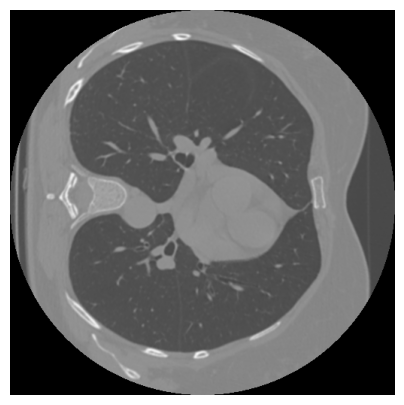

In [4]:
def plot_ct_scans_from_directory(study_dir):

        img = nib.load(study_dir)
        volume = img.get_fdata()

        print("CT Scan Shape: ", np.array(volume).shape)

        # Plot the whole volume (using a max intensity projection)
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        axes.imshow(volume[:, :, volume.shape[2] // 2], cmap="gray")  # Middle slice of the volume
        axes.axis('off')  # No axis for better visual
        plt.show()

study_directory = "./MosMedData/CT-0/study_0080.nii"

plot_ct_scans_from_directory(study_directory)

In [12]:
def move_random_files(src_dir, dest_dir, num_files=82):
    """
    Moves a specified number of random files from src_dir to dest_dir.
    
    :param src_dir: Source directory containing files
    :param dest_dir: Destination directory to move files to
    :param num_files: Number of files to move (default is 82)
    """
    if not os.path.exists(src_dir):
        raise ValueError("Source directory does not exist.")
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]
    
    if len(files) < num_files:
        raise ValueError("Not enough files in source directory to move.")
    
    files_to_move = random.sample(files, num_files)
    
    for file in files_to_move:
        shutil.move(os.path.join(src_dir, file), os.path.join(dest_dir, file))
    
    print(f"Moved {len(files_to_move)} files from {src_dir} to {dest_dir}.")

move_random_files("./MosMedData/CT-1", "./MosMedData/CT-23", num_files=82)

Moved 82 files from ./MosMedData/CT-1 to ./MosMedData/CT-23.


In [16]:
shutil.rmtree("./MosMedData/CT-1")

for dirpath, dirnames, filenames in os.walk("MosMedData"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'MosMedData'.
There are 0 directories and 254 images in 'MosMedData\CT-0'.
There are 0 directories and 254 images in 'MosMedData\CT-23'.


In [ ]:
def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 100
    desired_width = 224
    desired_height = 224
    
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]

    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=3)
    return img

def process_scan(volume):
    """Read and resize volume"""

    volume = normalize(volume)
    volume = resize_volume(volume)
    
    return volume

In [12]:
def split_nii_files(input_dirs, output_root):
    """
    Splits each .nii.gz file in the specified directories into two equal parts 
    and saves them under the same subdirectory structure in the output directory.

    Parameters:
    - input_dirs (list): List of directories containing .nii.gz files.
    - output_root (str): Root directory where processed files will be stored.
    """

    # Ensure output root exists
    os.makedirs(output_root, exist_ok=True)

    for input_dir in input_dirs:
        # Define subdirectory in output root (e.g., Processed_CT/CT-0)
        study_name = os.path.basename(input_dir)
        study_output_dir = os.path.join(output_root, study_name)
        os.makedirs(study_output_dir, exist_ok=True)

        # Get all .nii.gz files in the directory
        nii_files = [f for f in os.listdir(input_dir) if f.endswith(".nii")]

        for nii_file in nii_files:
            input_path = os.path.join(input_dir, nii_file)

            # Load the original NIfTI file
            img = nib.load(input_path)
            data = img.get_fdata()
            affine = img.affine  # Preserve spatial info
            header = img.header  # Preserve metadata

            data = process_scan(data)  # Preprocessing function (normalize, resize, etc.)

            # Get number of slices
            num_slices = data.shape[2]
            slices_per_part = num_slices // 3  # Two equal parts

            # Define a directory for the specific study
            file_study_name = os.path.splitext(nii_file)[0]  # Remove .nii.gz extension
            file_output_dir = os.path.join(study_output_dir, file_study_name)
            os.makedirs(file_output_dir, exist_ok=True)

            # Split into 3 parts
            for i in range(3):
                start_slice = i * slices_per_part
                end_slice = start_slice + slices_per_part

                if i == 2:  # Ensure last file gets all remaining slices
                    end_slice = num_slices

                # Extract subset of slices
                new_data = data[:, :, start_slice:end_slice]

                # Create new NIfTI image
                new_img = nib.Nifti1Image(new_data, affine, header)

                # Save new file
                output_file = os.path.join(file_output_dir, f"split_part_{i+1}.nii")
                nib.save(new_img, output_file)
                print(f"Saved: {output_file}")

# Example usage:
input_dirs = ["./MosMedData/CT-0", "./MosMedData/CT-23"]
output_root = "Processed_CT"
split_nii_files(input_dirs, output_root)

Saved: Processed_CT\CT-0\study_0001\split_part_1.nii
Saved: Processed_CT\CT-0\study_0001\split_part_2.nii
Saved: Processed_CT\CT-0\study_0001\split_part_3.nii
Saved: Processed_CT\CT-0\study_0002\split_part_1.nii
Saved: Processed_CT\CT-0\study_0002\split_part_2.nii
Saved: Processed_CT\CT-0\study_0002\split_part_3.nii
Saved: Processed_CT\CT-0\study_0003\split_part_1.nii
Saved: Processed_CT\CT-0\study_0003\split_part_2.nii
Saved: Processed_CT\CT-0\study_0003\split_part_3.nii
Saved: Processed_CT\CT-0\study_0004\split_part_1.nii
Saved: Processed_CT\CT-0\study_0004\split_part_2.nii
Saved: Processed_CT\CT-0\study_0004\split_part_3.nii
Saved: Processed_CT\CT-0\study_0005\split_part_1.nii
Saved: Processed_CT\CT-0\study_0005\split_part_2.nii
Saved: Processed_CT\CT-0\study_0005\split_part_3.nii
Saved: Processed_CT\CT-0\study_0006\split_part_1.nii
Saved: Processed_CT\CT-0\study_0006\split_part_2.nii
Saved: Processed_CT\CT-0\study_0006\split_part_3.nii
Saved: Processed_CT\CT-0\study_0007\split_part

In [13]:
def count_directories(path):
    # List all items in the directory and filter for directories
    return len([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])

# Example usage:
path = "Processed_CT/CT-23"
path2 = "Processed_CT/CT-0"

print(f"Number of directories: {count_directories(path2)}")
print(f"Number of directories: {count_directories(path)}")

Number of directories: 254
Number of directories: 254


CT Scan Shape:  (224, 224, 33)


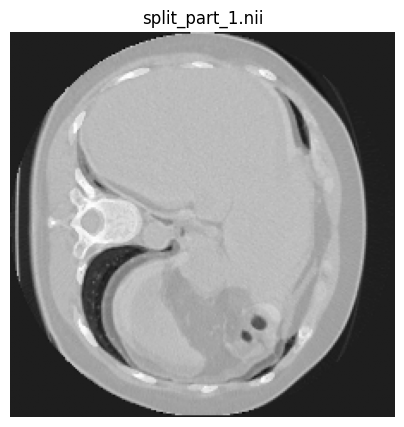

CT Scan Shape:  (224, 224, 33)


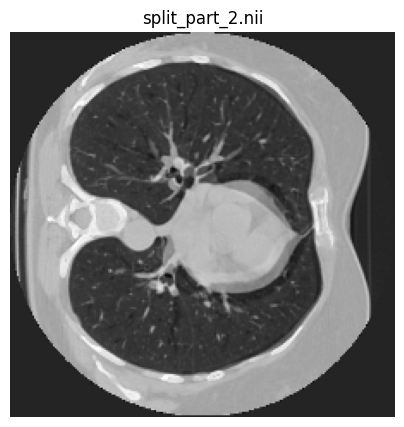

CT Scan Shape:  (224, 224, 34)


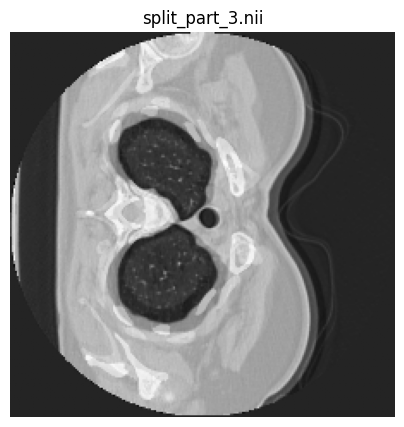

CT Scan Shape:  (224, 224, 33)


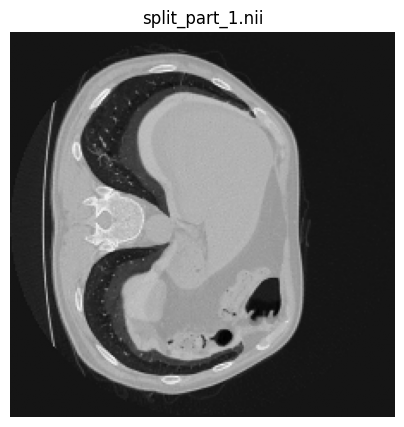

CT Scan Shape:  (224, 224, 33)


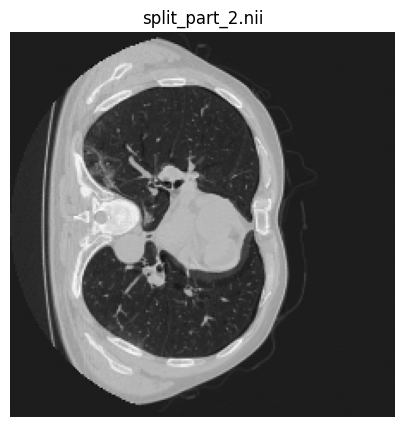

CT Scan Shape:  (224, 224, 34)


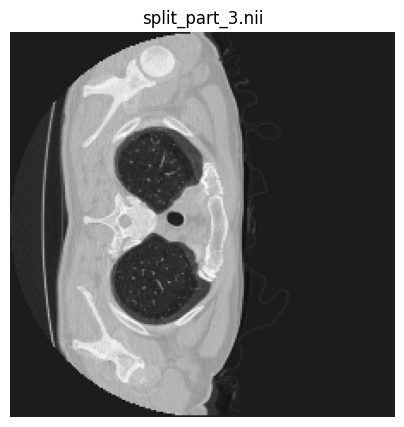

In [14]:
# Function to load and plot the NIfTI files from the specified directory
def plot_ct_scans_from_directory(study_dir):
    # Get all the .nii files in the directory
    nii_files = [f for f in os.listdir(study_dir) if f.endswith('.nii')]
    
    # Plot each file
    for nii_file in nii_files:
        # Load the NIfTI file

        nii_path = os.path.join(study_dir, nii_file)
        img = nib.load(nii_path)
        volume = img.get_fdata()

        print("CT Scan Shape: ", np.array(volume).shape)

        # Plot the whole volume (using a max intensity projection)
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        axes.imshow(volume[:, :, volume.shape[2] // 2], cmap="gray")  # Middle slice of the volume
        axes.set_title(nii_file)
        axes.axis('off')  # No axis for better visual
        plt.show()

study_directory = "./Processed_CT/CT-0/study_0080"
plot_ct_scans_from_directory(study_directory)



study_directory = "./Processed_CT/CT-23/study_0965"
plot_ct_scans_from_directory(study_directory)